In [1]:
import tqdm as notebook_tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split

MODEL_NAME = "Rostlab/prot_bert" 
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu" # using mps instead of cuda for training on mac
#DEVICE = "cpu"  # use GPU if available, otherwise CPU
print(f"Using device: {DEVICE}")
NUM_CLASSES = 6  # num classes for classification
BATCH_SIZE = 16
EPOCHS = 5
LR = 0.001

Using device: mps


In [2]:
import pandas as pd

records = []  # uniprot_ac, kingdom, type_, sequence, label
with open("/Users/jonas/Desktop/Uni/PBL/data/complete_set_unpartitioned.fasta", "r") as f:
    current_record = None
    for line in f:
        if line.startswith(">"):
            if current_record is not None:
                if current_record["sequence"] is not None and current_record["label"] is not None:
                    # Save the previous record before starting a new one
                    records.append(current_record)
                else:
                    # If the previous record is incomplete, skip it
                    print("Skipping incomplete record:", current_record)
            # Start a new record
            uniprot_ac, kingdom, type_ = line[1:].strip().split("|")
            current_record = {"uniprot_ac": uniprot_ac, "kingdom": kingdom, "type": type_, "sequence": None, "label": None}
        else:
            # Check if the line contains a sequence or a label
            if current_record["sequence"] is None:
                current_record["sequence"] = line.strip()
            elif current_record["label"] is None:
                current_record["label"] = line.strip()
            else:
                # If both sequence and label are already set, skip this line
                print("Skipping extra line in record:", current_record)
    # Save the last record if it's complete
    if current_record is not None:
        if current_record["sequence"] is not None and current_record["label"] is not None:
            records.append(current_record)
        else:
            print("Skipping incomplete record:", current_record)

"""
# Save the DataFrame to a CSV file
df_raw.to_csv("/Users/jonas/Desktop/Uni/PBL/data/complete_set_unpartitioned.csv", index=False)
"""
# Print the number of records
print(f"Total records: {len(records)}")
df_raw = pd.DataFrame(records)
df_raw.head()


Total records: 25693


,uniprot_ac,kingdom,type,sequence,label
0,Q8TF40,EUKARYA,NO_SP,MAPTLFQKLFSKRTGLGAPGRDARDPDCGFSWPLPEFDPSQIRLIV...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
1,Q1ENB6,EUKARYA,NO_SP,MDFTSLETTTFEEVVIALGSNVGNRMNNFKEALRLMKDYGISVTRH...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
2,P36001,EUKARYA,NO_SP,MDDISGRQTLPRINRLLEHVGNPQDSLSILHIAGTNGKETVSKFLT...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
3,P55317,EUKARYA,NO_SP,MLGTVKMEGHETSDWNSYYADTQEAYSSVPVSNMNSGLGSMNSMNT...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
4,P35583,EUKARYA,NO_SP,MLGAVKMEGHEPSDWSSYYAEPEGYSSVSNMNAGLGMNGMNTYMSM...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...


In [ ]:
df = df_raw[~df_raw["label"].str.contains("P")]
df.describe()

,uniprot_ac,kingdom,type,sequence,label
count,25580,25580,25580,25580,25580
unique,25580,4,5,24367,1878
top,Q8TF40,EUKARYA,NO_SP,MKLSRRSFMKANAVAAAAAAAGLSVPGVARAVVGQQEAIKWDKAPC...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
freq,1,20423,19036,41,16382


In [4]:
label_map = {'S': 0, 'T': 1, 'L': 2, 'I': 3, 'M': 4, 'O': 5}

df_encoded = df.copy()
df_encoded["label"] = df_encoded["label"].apply(lambda x: [label_map[c] for c in x if c in label_map])
df_encoded = df_encoded[df_encoded["label"].map(len) > 0]  # Remove rows with empty label lists

# make random smaller dataset
#df_encoded = df_encoded.sample(frac=0.4, random_state=42)

sequences = df_encoded["sequence"].tolist()
label_seqs = df_encoded["label"].tolist()

df_encoded.describe()


,uniprot_ac,kingdom,type,sequence,label
count,25580,25580,25580,25580,25580
unique,25580,4,5,24367,1878
top,Q8TF40,EUKARYA,NO_SP,MKLSRRSFMKANAVAAAAAAAGLSVPGVARAVVGQQEAIKWDKAPC...,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
freq,1,20423,19036,41,16382


In [5]:
# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
encoder = BertModel.from_pretrained(MODEL_NAME)
encoder.to(DEVICE)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30, 1024, padding_idx=0)
    (position_embeddings): Embedding(40000, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-29): 30 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.0, i

In [6]:
# Stratify by sequence length to avoid ValueError
train_seqs, test_seqs, train_label_seqs, test_label_seqs = train_test_split(
    sequences, label_seqs, test_size=0.3, random_state=42
)

In [7]:
# Load the data 
class SPDataset(Dataset):
    def __init__(self, sequences, label_seqs, label_map):
        self.label_map = label_map
        self.label_seqs = label_seqs
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        # preprocess the sequence (insert spaces between amino acids)
        seq_processed = " ".join(list(seq))
        labels = self.label_seqs[idx]
        # Tokenize the sequence (padding to ensure all sequences are the same length -> 512 tokens) 
        encoded = tokenizer(seq_processed, return_tensors="pt",
                            padding="max_length", truncation=True, max_length=512)
        input_ids = encoded['input_ids'].squeeze(0)
        attention_mask = encoded['attention_mask'].squeeze(0)
        
        # Build a label tensor of the same length as input_ids.
        # For tokens beyond the original sequence length, assign -100 so that loss func ignores them.
        orig_length = len(seq)
        token_labels = []
        
        for i in range(input_ids.size(0)):
            if i == 0 or i > orig_length:  
                token_labels.append(-100)  # ignore padding tokens
            else:
                # Use the already encoded label directly
                token_labels.append(labels[i-1])
        labels_tensor = torch.tensor(token_labels)
        
        return {
            'input_ids': input_ids, # tokenized and padded 
            'attention_mask': attention_mask, # differentiate between padding and non-padding tokens
            'labels': labels_tensor # aligned label tensor
        }

train_dataset = SPDataset(train_seqs, train_label_seqs, label_map)
test_dataset = SPDataset(test_seqs, test_label_seqs, label_map)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchcrf import CRF

class SPCNNClassifier(nn.Module):
    def __init__(self, encoder_model, num_labels):
        super().__init__()
        self.encoder = encoder_model  
        self.dropout = nn.Dropout(0.2)
        hidden_size = self.encoder.config.hidden_size
        # detects local features in the sequence
        self.conv = nn.Conv1d(in_channels=hidden_size, out_channels=1024, kernel_size=8, dilation=2, padding=7)
        # Normalize the convolution output (expects shape: (batch, 1024, seq_len))
        self.bn_conv = nn.BatchNorm1d(1024)
        # 2 layer long short term memory network
        self.lstm = nn.LSTM(input_size=1024, hidden_size=512, num_layers=2, bidirectional=True, batch_first=True)
        # dense layer
        self.classifier = nn.Linear(512 * 2, num_labels)
        self.crf = CRF(num_labels, batch_first=True)



    def forward(self, input_ids, attention_mask, labels=None):
        # Encode with BERT
        encoder_output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = encoder_output.last_hidden_state  # (batch, seq_len, hidden_size)
        #residue_embeddings = output.last_hidden_state[:, 1:-1, :]  # Remove CLS/SEP

        #  CNN 1
        # Apply conv, then batch normalization and ReLU
        x_conv = self.conv(hidden_states.transpose(1, 2))  # (batch, 1024, seq_len)
        x_conv = self.bn_conv(x_conv)
        x_conv = F.relu_(x_conv)                          # (batch, 1024, seq_len)

        # Transpose CNN output for LSTM: (batch, seq_len, features)
        x_lstm_input = x_conv.transpose(1, 2)           # (batch, seq_len, 1024)

        # Apply BiLSTM
        lstm_out, _ = self.lstm(x_lstm_input)            # (batch, seq_len, 1024)

        # Classifier to num_labels
        x_linear = self.classifier(lstm_out)             # (batch, seq_len, num_labels)
        logits = self.dropout(x_linear)                  # (batch, seq_len, num_labels)

        if labels is not None:
            # Replace ignore-index (-100) with a valid label (0) since CRF doesn't support -100
            mod_labels = labels.clone()
            mod_labels[labels == -100] = 0
            loss = -self.crf(logits, mod_labels, mask=attention_mask.bool(), reduction='mean')
            return loss
        else:
            predictions = self.crf.decode(logits, mask=attention_mask.bool())
            return predictions



In [9]:
from transformers import get_linear_schedule_with_warmup

# Initialize the model
model = SPCNNClassifier(encoder, NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load("/Users/jonas/Desktop/Uni/PBL/models/prot_bert_linear_classifier_v5.pt", map_location=DEVICE))

# optimizer 
optimizer = torch.optim.AdamW([
    {"params": model.encoder.encoder.layer[-4:].parameters(), "lr": 5e-6},
    {"params": model.conv.parameters(), "lr": 1e-3},
    {"params": model.classifier.parameters(), "lr": 1e-3},
    {"params": model.lstm.parameters(), "lr": 1e-3},
    {"params": model.crf.parameters(), "lr": 1e-3},
])  # adjust weight_decay as needed

total_steps = len(train_loader) * EPOCHS
# scheduler for learning rate
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)


In [10]:
# Compute sequence-level accuracy, skipping -100 (ignored) positions
def sequence_level_accuracy(preds_flat, labels_flat, test_label_seqs):
    # reconstruct the sequences from the flat predictions
    seq_lengths = [len(seq) for seq in test_label_seqs]
    preds_seq = []
    labels_seq = []
    idx = 0
    for l in seq_lengths:
        preds_seq.append(preds_flat[idx:idx+l])
        labels_seq.append(labels_flat[idx:idx+l])
        idx += l

    # check if the valid predictions match the labels
    correct = 0
    for pred, label in zip(preds_seq, labels_seq):
        is_valid = [l != -100 for l in label]
        valid_preds = [p for p, valid in zip(pred, is_valid) if valid]
        valid_labels = [l for l, valid in zip(label, is_valid) if valid]
        if valid_preds == valid_labels:
            correct += 1

    total = len(seq_lengths)
    return correct / total if total > 0 else 0.0


In [ ]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from torch.amp import autocast, GradScaler
import gc

writer = SummaryWriter(log_dir="/Users/jonas/Desktop/Uni/PBL/logs/prot_bert_linear_classifier_v5")
scaler = GradScaler()

# Freeze encoder parameters initially (last 10 layers)
for param in model.encoder.encoder.layer[:-10].parameters():
    param.requires_grad = False
model.encoder.gradient_checkpointing_enable()  # Enable gradient checkpointing for memory efficiency

# training loop
for epoch in range(EPOCHS):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", unit="batch")
    total_loss = 0  # total epoch loss

    for batch in pbar:
        try:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            token_labels = batch['labels'].to(DEVICE)

            optimizer.zero_grad()  # reset gradients

            loss = model(input_ids, attention_mask, token_labels)  # single forward pass

            scaler.scale(loss).backward()      # backpropagation
            scaler.unscale_(optimizer)         # Unscale gradients before clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # gradient clipping
            scaler.step(optimizer)             # update weights
            scaler.update()                    # update scaler
            scheduler.step()                   # update learning rate

            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

        except RuntimeError as e:
            print("Error during training:", e)
            gc.collect()
            torch.mps.empty_cache()
            continue

    # Optionally clear the cache once per epoch if needed.
    torch.mps.empty_cache()  
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_train_loss:.4f}")
    writer.add_scalar("Loss/train", avg_train_loss, epoch)

writer.flush()
writer.close()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Epoch 1/5: 100%|██████████| 1120/1120 [2:25:28<00:00,  7.79s/batch, loss=0.0744]


Epoch 1, Loss: 2.6852


Epoch 2/5: 100%|██████████| 1120/1120 [2:25:17<00:00,  7.78s/batch, loss=0.493]  


Epoch 2, Loss: 2.2232


Epoch 3/5: 100%|██████████| 1120/1120 [2:24:51<00:00,  7.76s/batch, loss=0.124]  


Epoch 3, Loss: 1.6904


Epoch 4/5: 100%|██████████| 1120/1120 [2:24:52<00:00,  7.76s/batch, loss=0.154]  


Epoch 4, Loss: 1.2726


Epoch 5/5: 100%|██████████| 1120/1120 [2:24:54<00:00,  7.76s/batch, loss=0.0363] 

Epoch 5, Loss: 0.9077


In [12]:
torch.save(model.state_dict(), "/Users/jonas/Desktop/Uni/PBL/models/prot_bert_linear_classifier_v5_2.pt")

Classification Report:
              precision    recall  f1-score   support

           S       0.94      0.94      0.94     25619
           T       0.97      0.94      0.96      6739
           L       0.97      0.96      0.97     14328
           I       0.97      0.98      0.98    358968
           M       0.87      0.84      0.86     21858
           O       0.92      0.92      0.92    108891

    accuracy                           0.96    536403
   macro avg       0.94      0.93      0.94    536403
weighted avg       0.96      0.96      0.96    536403

F1 Score (weighted): 0.9584
F1 Score (macro): 0.9363
Sequence Level Accuracy: 0.8525
Matthews Correlation Coefficient (MCC): 0.9177
Token-level Accuracy: 0.9584


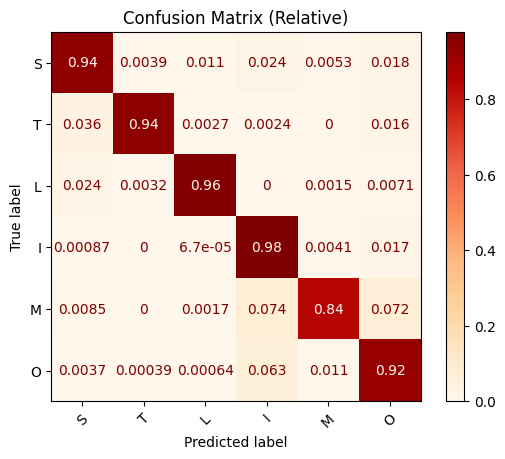

In [15]:
# Evaluation

import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import classification_report, f1_score, matthews_corrcoef, accuracy_score, classification_report

model = SPCNNClassifier(encoder, NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load("/Users/jonas/Desktop/Uni/PBL/models/prot_bert_linear_classifier_v5_2.pt", map_location=DEVICE))


val_loss = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        # Compute loss using CRF (pass labels)
        loss = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        val_loss += loss.item()

        # Decode predictions using CRF (no labels passed)
        predictions = model(input_ids=input_ids, attention_mask=attention_mask)  # List[List[int]]

        # Loop through batch and collect valid tokens
        for pred_seq, label_seq, mask in zip(predictions, labels, attention_mask):
            for pred, true, is_valid in zip(pred_seq, label_seq, mask):
                if true.item() != -100 and is_valid.item() == 1:
                    all_preds.append(pred)
                    all_labels.append(true.item())


# Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=list(label_map.keys())))

# F1 Score weighted
from sklearn.metrics import classification_report, f1_score, matthews_corrcoef, accuracy_score, classification_report
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"F1 Score (weighted): {f1:.4f}")
# F1 Score macro
f1_macro = f1_score(all_labels, all_preds, average='macro')
print(f"F1 Score (macro): {f1_macro:.4f}")

# Sequence Level Accuracy
seq_acc_val = sequence_level_accuracy(all_preds, all_labels, test_label_seqs)
print(f"Sequence Level Accuracy: {seq_acc_val:.4f}")

# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(all_labels, all_preds)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Token-level Accuracy
token_acc = accuracy_score(all_labels, all_preds)
print(f"Token-level Accuracy: {token_acc:.4f}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds, labels=list(label_map.values()))
cm_relative = cm.astype("float") / cm.sum(axis=1, keepdims=True)  # normalize per true label
disp = ConfusionMatrixDisplay(confusion_matrix=cm_relative, display_labels=list(label_map.keys()))
disp.plot(cmap="OrRd", xticks_rotation=45)
plt.title("Confusion Matrix (Relative)")
plt.show()

writer.add_scalar("Loss/test", val_loss)

writer.flush()
writer.close()


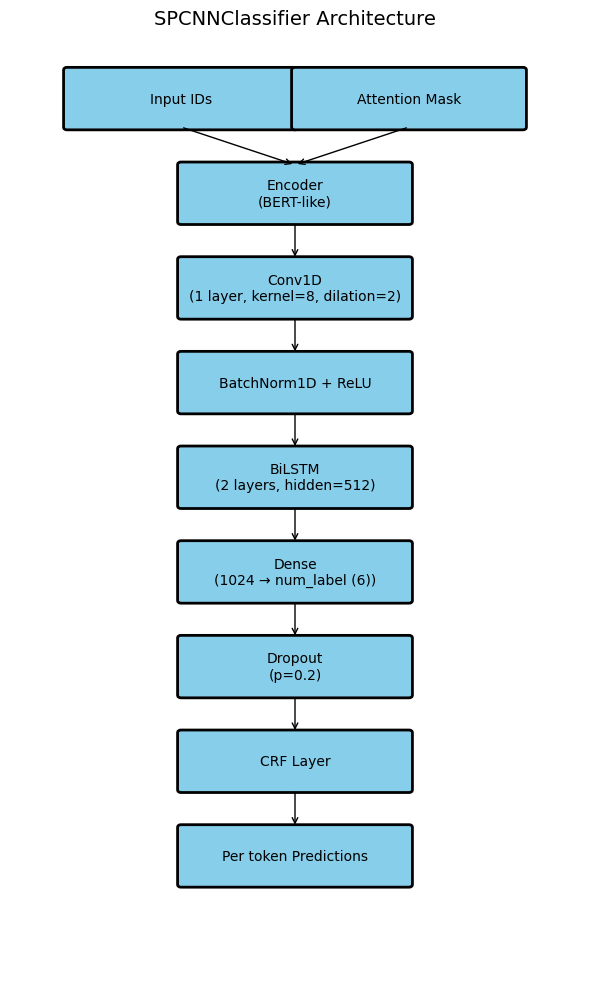

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def draw_vertical_model():
    fig, ax = plt.subplots(figsize=(6, 10))
    ax.axis('off')

    # Define blocks with (x, y)
    blocks = [
        ("Input IDs", 0.5, 9.0),
        ("Attention Mask", 2.5, 9.0),
        ("Encoder\n(BERT-like)", 1.5, 8.0),
        ("Conv1D\n(1 layer, kernel=8, dilation=2)", 1.5, 7.0),
        ("BatchNorm1D + ReLU", 1.5, 6.0),
        ("BiLSTM\n(2 layers, hidden=512)", 1.5, 5.0),
        ("Dense\n(1024 → num_label (6))", 1.5, 4.0),
        ("Dropout\n(p=0.2)", 1.5, 3.0),
        ("CRF Layer", 1.5, 2.0),
        ("Per token Predictions", 1.5, 1.0)
    ]

    box_width = 2.0
    box_height = 0.6

    # Draw blocks
    for label, x, y in blocks:
        rect = mpatches.FancyBboxPatch((x, y), box_width, box_height, boxstyle="round,pad=0.03",
                                       edgecolor='black', facecolor='skyblue', linewidth=2)
        ax.add_patch(rect)
        ax.text(x + box_width / 2, y + box_height / 2, label, ha='center', va='center', fontsize=10)

    # Draw arrows
    for i in range(2, len(blocks) - 1):  # skip input IDs and mask arrows
        x1 = blocks[i][1] + box_width / 2
        y1 = blocks[i][2]
        y2 = blocks[i+1][2] + box_height
        ax.annotate('', xy=(x1, y2), xytext=(x1, y1),
                    arrowprops=dict(facecolor='black', arrowstyle='->'))

    # Draw arrows from inputs
    ax.annotate('', xy=(1.5 + box_width/2, 8.6), xytext=(0.5 + box_width/2, 9.0),
                arrowprops=dict(facecolor='black', arrowstyle='->'))
    ax.annotate('', xy=(1.5 + box_width/2, 8.6), xytext=(2.5 + box_width/2, 9.0),
                arrowprops=dict(facecolor='black', arrowstyle='->'))

    plt.title("SPCNNClassifier Architecture", fontsize=14)
    plt.ylim(0, 10)
    plt.xlim(0, 5)
    plt.tight_layout()
    plt.show()

draw_vertical_model()
